# Feature Engineering

- With a new dataset, completely clean, and after insights into all the data, it's time to transform and create useful and more features to train the model      

    - Age difference
    - Height difference
    - Player Rating
    - Player Surface Rating
    - Win percentage in the last 10, 25, 50, 100 matches
    - Mirror all games to change the winner player (data augmentation)

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [114]:
df = pd.read_csv('../data/processed/2_clean_data.csv', sep=';', encoding='utf-8')
df.head()
df['PLAYER_0_ID'] = df['PLAYER_0_ID'].astype(str)
df['PLAYER_1_ID'] = df['PLAYER_1_ID'].astype(str)

---

## Age Difference

In [115]:
df['AGE_DIFF'] = (df['PLAYER_0_AGE'] - df['PLAYER_1_AGE']).round(2)
df['AGE_DIFF']

0         2.0
1         0.0
2         0.0
3        -1.7
4        -4.7
         ... 
187728   -3.0
187729    3.7
187730    0.9
187731   -0.4
187732   -3.2
Name: AGE_DIFF, Length: 187733, dtype: float64

In [116]:
df['AGE_DIFF'].describe()

count    187733.000000
mean         -0.047054
std           5.520633
min         -41.700000
25%          -3.600000
50%          -0.100000
75%           3.500000
max          33.900000
Name: AGE_DIFF, dtype: float64

<Axes: ylabel='AGE_DIFF'>

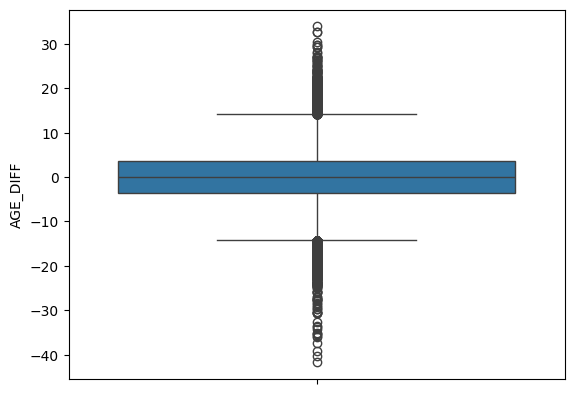

In [117]:
plt.figure()
sns.boxplot(data=df['AGE_DIFF'])

<Axes: xlabel='AGE_DIFF', ylabel='Count'>

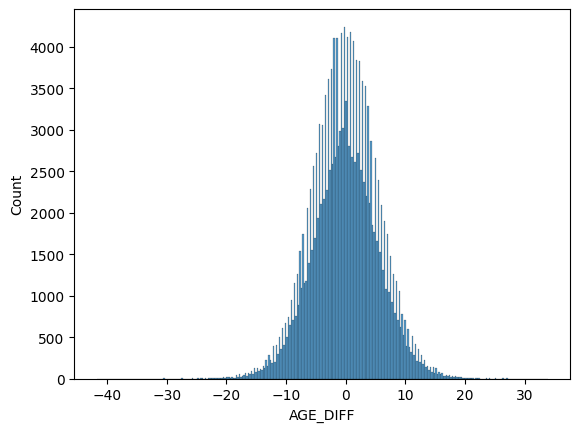

In [118]:
plt.figure()
sns.histplot(df['AGE_DIFF'])

---

## Height Difference

In [119]:
df['HT_DIFF'] = (df['PLAYER_0_AGE'] - df['PLAYER_1_AGE']).round(2)
df['HT_DIFF']

0         2.0
1         0.0
2         0.0
3        -1.7
4        -4.7
         ... 
187728   -3.0
187729    3.7
187730    0.9
187731   -0.4
187732   -3.2
Name: HT_DIFF, Length: 187733, dtype: float64

In [120]:
df['HT_DIFF'].describe()

count    187733.000000
mean         -0.047054
std           5.520633
min         -41.700000
25%          -3.600000
50%          -0.100000
75%           3.500000
max          33.900000
Name: HT_DIFF, dtype: float64

<Axes: ylabel='HT_DIFF'>

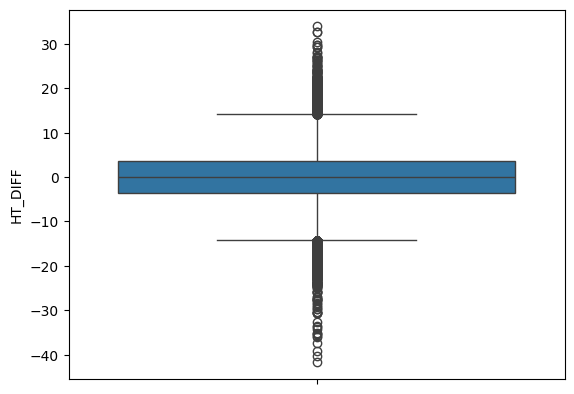

In [121]:
plt.figure()
sns.boxplot(data=df['HT_DIFF'])

<Axes: xlabel='HT_DIFF', ylabel='Count'>

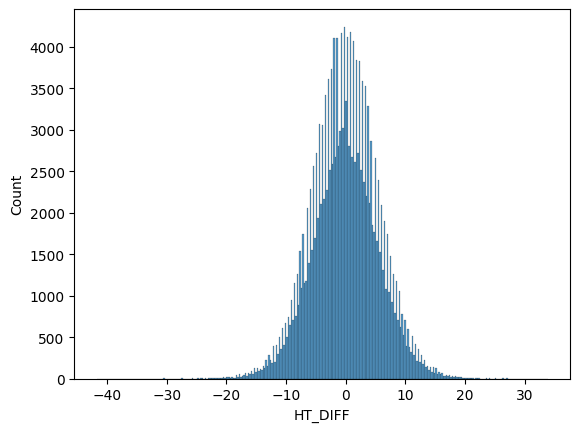

In [122]:
plt.figure()
sns.histplot(data=df['HT_DIFF'])

---

## Player Rating

- The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess or esports. It is named after its creator Arpad Elo, a Hungarian-American chess master and physics professor.

- The Elo system was invented as an improved chess rating system over the previously used Harkness rating system, but it is also used as a rating system in association football (soccer), American football, baseball, basketball, pool, various board games and esports, and, more recently, large language models.

- The difference in the ratings between two players serves as a predictor of the outcome of a match. Two players with equal ratings who play against each other are expected to score an equal number of wins. A player whose rating is 100 points greater than their opponent's is expected to score 64%; if the difference is 200 points, then the expected score for the stronger player is 76%.

- In tennis, the Elo-based Universal Tennis Rating (UTR) rates players on a global scale, regardless of age, gender, or nationality. It is the official rating system of major organizations such as the Intercollegiate Tennis Association and World TeamTennis and is frequently used in segments on the Tennis Channel. The algorithm analyzes more than 8 million match results from over 800,000 tennis players worldwide. On May 8, 2018, Rafael Nadal—having won 46 consecutive sets in clay court matches—had a near-perfect clay UTR of 16.42.

#### Calculating Elo

- The expected score formula for the player is calculated by

    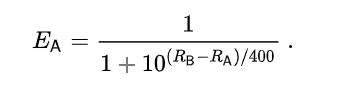
    
    - Ea - Expected Score for player A
    - Ra - Player A rating
    - Rb - Player B rating


- New rating 

    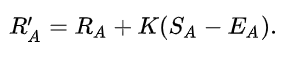

    - R'a - New Elo 
    - Ra - Player A rating
    - K - Maximun adjustment per game
    - Sa - Percentage of games won
    - Ea - Expected Score for player A

In [123]:
from typing import Any
players: dict[str, Any] = {}

In [124]:
def expected_score(rating_a: float, rating_b: float) -> tuple[float, float]:
    expected_score_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    expected_score_b = 1 / (1 + 10 ** ((rating_a - rating_b) / 400))
    return expected_score_a, expected_score_b

def calculate_games(score) -> tuple[float, float]:
    games_a = 0
    games_b = 0

    for set in score.strip().split(' '):
        match = re.match(r'(\d+)-(\d+)(?:\(\d+\))?', set)
        if match:
            games_a += int(match.group(1))
            games_b += int(match.group(2))

    total_games = games_a + games_b
    percent_game_a = games_a / total_games
    percent_game_b = games_b / total_games
    return percent_game_a, percent_game_b

def calculate_rating(rating: float, perc_games:float, expec_win: float) -> float: #NOSONAR
    #if it was an easy victory, the player receives more points and vice versa
    if perc_games >= 0.7:
        K = 50
    elif perc_games >= 0.5:
        K = 40
    else:
        K = 30
        
    new_rating = round(rating + K * (perc_games - expec_win), 3) #NOSONAR
    return new_rating

for index, row in df.iterrows():
    player_0, player_1 = row['PLAYER_0_ID'], row['PLAYER_1_ID']
    players.setdefault(player_0, {}).setdefault('RATING', 2000)
    players.setdefault(player_1, {}).setdefault('RATING', 2000)
    percent_game_0, percent_game_1 = calculate_games(row['SCORE'])
    e0, e1 = expected_score(players[player_0]['RATING'], players[player_1]['RATING'])

    new_rating_0 = calculate_rating(players[player_0]['RATING'], percent_game_0, e0)
    new_rating_1 = calculate_rating(players[player_1]['RATING'], percent_game_1, e1)

    df.at[index, 'PLAYER_0_RATING'], df.at[index, 'PLAYER_1_RATING'] = players[player_0]['RATING'], players[player_1]['RATING']
    df.at[index, 'RATING_DIFF'] = round(players[player_0]['RATING'] - players[player_1]['RATING'], 3)
    players[player_0]['RATING'], players[player_1]['RATING'] = new_rating_0, new_rating_1

In [125]:
# Top 5 players in 2024
df[df['TOURNEY_DATE'] > '2024-01-01'].sort_values(by='PLAYER_0_RATING', ascending=False).drop_duplicates(subset='PLAYER_0_ID').head(6)

,SURFACE,TOURNEY_DATE,TOURNEY_LEVEL,PLAYER_0_ID,PLAYER_0_HAND,PLAYER_0_HT,PLAYER_0_AGE,PLAYER_1_ID,PLAYER_1_HAND,PLAYER_1_HT,PLAYER_1_AGE,SCORE,BEST_OF,AGE_DIFF,HT_DIFF,PLAYER_0_RATING,PLAYER_1_RATING,RATING_DIFF
185468,Hard,2024-03-18,M,206173,R,191.0,22.5,207830,R,183.0,23.4,6-4 6-2,3,-0.9,-0.9,2304.610,2154.469,150.141
184894,Hard,2024-01-15,G,104925,R,188.0,36.6,209976,R,188.0,18.4,6-2 6-7(5) 6-3 6-4,5,18.2,18.2,2276.011,2043.267,232.744
186036,Clay,2024-05-27,G,207989,R,183.0,21.0,200624,R,196.0,23.8,6-4 7-6(5) 6-3,5,-2.8,-2.8,2271.951,2201.671,70.280
186150,Grass,2024-06-10,A,200282,R,183.0,25.3,200267,R,185.0,25.0,7-5 6-4,3,0.3,0.3,2262.682,2103.542,159.140
184978,Hard,2024-01-15,G,106421,R,198.0,27.9,200325,R,188.0,24.7,3-6 6-7(1) 6-4 7-6(1) 6-0,5,3.2,3.2,2258.700,2185.487,73.213
184932,Hard,2024-01-15,G,105777,R,191.0,32.6,105916,R,188.0,31.9,4-6 6-3 7-6(1) 6-2,5,0.7,0.7,2249.215,2149.568,99.647


In [126]:
df[['PLAYER_0_RATING', 'PLAYER_1_RATING', 'RATING_DIFF']].describe()

,PLAYER_0_RATING,PLAYER_1_RATING,RATING_DIFF
count,187733.000000,187733.000000,187733.000000
mean,2174.213090,2139.325660,34.887430
std,74.760519,75.792647,77.744745
min,1920.429000,1919.215000,-289.818000
25%,2135.323000,2089.066000,-12.760000
50%,2184.234000,2153.715000,31.161000
75%,2224.385000,2193.980000,82.514000
max,2428.442000,2403.294000,426.995000


---

## Surface Rating

- It follows the same purpose, but now taking the surface as the main variable

In [127]:
# All functions and variables were created previously
for index, row in df.iterrows():
    player_0, player_1, surface = row['PLAYER_0_ID'], row['PLAYER_1_ID'], row['SURFACE']
    col_surface_rating = f'{surface.upper()}_RATING'
    players.setdefault(player_0, {}).setdefault(col_surface_rating, 2000)
    players.setdefault(player_1, {}).setdefault(col_surface_rating, 2000)
    percent_game_0, percent_game_1 = calculate_games(row['SCORE'])
    e0, e1 = expected_score(players[player_0][col_surface_rating], players[player_1][col_surface_rating])

    new_rating_0 = calculate_rating(players[player_0][col_surface_rating], percent_game_0, e0)
    new_rating_1 = calculate_rating(players[player_1][col_surface_rating], percent_game_1, e1)

    df.at[index, 'PLAYER_0_SURFACE_RATING'], df.at[index, 'PLAYER_1_SURFACE_RATING'] = players[player_0][col_surface_rating], players[player_1][col_surface_rating]
    df.at[index, 'SURFACE_RATING_DIFF'] = round(players[player_0][col_surface_rating] - players[player_1][col_surface_rating], 3)
    players[player_0][col_surface_rating], players[player_1][col_surface_rating] = new_rating_0, new_rating_1

In [128]:
# Top 5 players in 2024
df[df['TOURNEY_DATE'] > '2024-01-01'].sort_values(by='PLAYER_0_SURFACE_RATING', ascending=False).drop_duplicates(subset='PLAYER_0_ID').head(6)

,SURFACE,TOURNEY_DATE,TOURNEY_LEVEL,PLAYER_0_ID,PLAYER_0_HAND,PLAYER_0_HT,PLAYER_0_AGE,PLAYER_1_ID,PLAYER_1_HAND,PLAYER_1_HT,...,SCORE,BEST_OF,AGE_DIFF,HT_DIFF,PLAYER_0_RATING,PLAYER_1_RATING,RATING_DIFF,PLAYER_0_SURFACE_RATING,PLAYER_1_SURFACE_RATING,SURFACE_RATING_DIFF
185468,Hard,2024-03-18,M,206173,R,191.0,22.5,207830,R,183.0,...,6-4 6-2,3,-0.9,-0.9,2304.610,2154.469,150.141,2256.218,2107.144,149.074
184894,Hard,2024-01-15,G,104925,R,188.0,36.6,209976,R,188.0,...,6-2 6-7(5) 6-3 6-4,5,18.2,18.2,2276.011,2043.267,232.744,2229.340,2010.786,218.554
187096,Hard,2024-09-26,A,207989,R,183.0,21.3,208659,R,203.0,...,6-4 6-4,3,0.1,0.1,2271.744,2096.338,175.406,2223.254,2023.669,199.585
184978,Hard,2024-01-15,G,106421,R,198.0,27.9,200325,R,188.0,...,3-6 6-7(1) 6-4 7-6(1) 6-0,5,3.2,3.2,2258.700,2185.487,73.213,2216.654,2139.780,76.874
185721,Clay,2024-04-15,A,104745,L,185.0,37.8,207925,R,183.0,...,6-2 6-3,3,15.9,15.9,2239.996,2107.788,132.208,2215.871,2033.001,182.870
186895,Hard,2024-08-26,G,200282,R,183.0,25.5,106218,R,180.0,...,6-3 6-4 5-7 6-4,5,-5.5,-5.5,2249.688,2155.063,94.625,2201.445,2112.115,89.330


In [129]:
df[['SURFACE', 'PLAYER_0_ID', 'PLAYER_0_SURFACE_RATING']] \
    .sort_values(by='PLAYER_0_SURFACE_RATING', ascending=False) \
    .drop_duplicates(subset='PLAYER_0_ID') \
    .head(6)

,SURFACE,PLAYER_0_ID,PLAYER_0_SURFACE_RATING
46863,Clay,100437,2392.771
147819,Clay,104745,2327.301
53398,Clay,100656,2325.704
47351,Clay,100282,2323.225
69067,Clay,101426,2312.405
151768,Hard,104925,2309.762


In [130]:
df[['PLAYER_0_SURFACE_RATING', 'PLAYER_1_SURFACE_RATING']].describe()

,PLAYER_0_SURFACE_RATING,PLAYER_1_SURFACE_RATING
count,187733.000000,187733.000000
mean,2101.940392,2072.626611
std,66.537628,59.700178
min,1944.902000,1945.498000
25%,2047.693000,2016.523000
50%,2103.341000,2068.718000
75%,2149.067000,2117.654000
max,2392.771000,2385.763000


## Win Percentage (10, 25, 50, 100 last matches)

In [131]:
def calculate_win_percentage(list_match_results: list[int]):
	if len(list_match_results) == 0:
		return {
			'PERC_WIN_LAST_10': 0,
		 	'PERC_WIN_LAST_25': 0,
			'PERC_WIN_LAST_50': 0,
			'PERC_WIN_LAST_100': 0
			}
	perc_win_10 = round(list_match_results[:10].count(1) / len(list_match_results[:10]), 2) 
	perc_win_25 = round(list_match_results[:25].count(1) / len(list_match_results[:25]), 2) 
	perc_win_50 = round(list_match_results[:50].count(1) / len(list_match_results[:50]), 2) 
	perc_win_100 = round(list_match_results.count(1) / len(list_match_results), 2)
	return {
			'PERC_WIN_LAST_10': perc_win_10,
		 	'PERC_WIN_LAST_25': perc_win_25,
			'PERC_WIN_LAST_50': perc_win_50,
			'PERC_WIN_LAST_100': perc_win_100
			}
	
def add_df(df, index, player: str, perc_win: dict[float]):
	for i in ['10', '25', '50', '100']:
		df.at[index, f'PERC_{player}_WIN_LAST_{i}'] = perc_win[f'PERC_WIN_LAST_{i}']

def add_json(players: dict, player_id: str, perc_win: dict[float]):
	for i in ['10', '25', '50', '100']:
		players[player_id][f'PERC_WIN_LAST_{i}'] = perc_win[f'PERC_WIN_LAST_{i}']

players_results: dict[str, list[int]] = {}
for index, row in df.iterrows():
	player_0, player_1 = row['PLAYER_0_ID'], row['PLAYER_1_ID']
	players_results.setdefault(player_0, {}).setdefault('LIST_MATCH_RESULTS', [])
	players_results.setdefault(player_1, {}).setdefault('LIST_MATCH_RESULTS', [])
	
	list_match_results_0: list[int] = players_results[player_0]['LIST_MATCH_RESULTS']
	list_match_results_1: list[int] = players_results[player_1]['LIST_MATCH_RESULTS']

	perc_0_win = calculate_win_percentage(list_match_results_0) 
	perc_1_win = calculate_win_percentage(list_match_results_1) 

	add_df(df, index, '0', perc_0_win)
	add_df(df, index, '1', perc_1_win)
	
	df.at[index, 'LAST_10_WIN_DIFF'] = round(perc_0_win['PERC_WIN_LAST_10'] - perc_1_win['PERC_WIN_LAST_10'], 2)
	df.at[index, 'LAST_25_WIN_DIFF'] = round(perc_0_win['PERC_WIN_LAST_25'] - perc_1_win['PERC_WIN_LAST_25'], 2)
	df.at[index, 'LAST_50_WIN_DIFF'] = round(perc_0_win['PERC_WIN_LAST_50'] - perc_1_win['PERC_WIN_LAST_50'], 2)
	df.at[index, 'LAST_100_WIN_DIFF'] = round(perc_0_win['PERC_WIN_LAST_100'] - perc_1_win['PERC_WIN_LAST_100'], 2)


	if len(list_match_results_0) > 100:
		list_match_results_0.pop(0) 
		
	if len(list_match_results_1) > 100:
		list_match_results_1.pop(0)
		
	list_match_results_0.append(1)
	list_match_results_1.append(0)

	perc_0_win = calculate_win_percentage(list_match_results_0) 
	perc_1_win = calculate_win_percentage(list_match_results_1) 
	add_json(players, player_0, perc_0_win)
	add_json(players, player_1, perc_1_win)

In [132]:
df.tail()

,SURFACE,TOURNEY_DATE,TOURNEY_LEVEL,PLAYER_0_ID,PLAYER_0_HAND,PLAYER_0_HT,PLAYER_0_AGE,PLAYER_1_ID,PLAYER_1_HAND,PLAYER_1_HT,...,PERC_0_WIN_LAST_50,PERC_0_WIN_LAST_100,PERC_1_WIN_LAST_10,PERC_1_WIN_LAST_25,PERC_1_WIN_LAST_50,PERC_1_WIN_LAST_100,LAST_10_WIN_DIFF,LAST_25_WIN_DIFF,LAST_50_WIN_DIFF,LAST_100_WIN_DIFF
187728,Clay,2024-02-03,D,212051,U,185.0,18.8,209943,R,188.0,...,0.33,0.33,0.00,0.00,0.00,0.00,0.33,0.33,0.33,0.33
187729,Hard,2024-02-02,D,122533,R,175.0,26.9,202475,R,184.0,...,0.83,0.83,0.40,0.40,0.40,0.40,0.43,0.43,0.43,0.43
187730,Hard,2024-02-02,D,144748,R,185.0,27.3,144775,R,183.0,...,0.00,0.00,0.50,0.50,0.50,0.50,-0.50,-0.50,-0.50,-0.50
187731,Hard,2024-02-02,D,122533,R,175.0,26.9,144748,R,185.0,...,0.86,0.86,0.33,0.33,0.33,0.33,0.53,0.53,0.53,0.53
187732,Hard,2024-02-02,D,202475,R,185.0,23.2,144775,R,183.0,...,0.33,0.33,0.33,0.33,0.33,0.33,0.00,0.00,0.00,0.00


### Creating JSON with players ratings

In [133]:
import json

In [134]:
# TODO: Add player name
json_file_path = '../data/players_ratings.json'

with open(json_file_path, 'w') as json_file:
    json.dump(players, json_file, indent=4)

---

## Change Score

- All scores refer to player_0's match result, so all scores will to be 0

In [135]:
df['SCORE'] = 0
df

,SURFACE,TOURNEY_DATE,TOURNEY_LEVEL,PLAYER_0_ID,PLAYER_0_HAND,PLAYER_0_HT,PLAYER_0_AGE,PLAYER_1_ID,PLAYER_1_HAND,PLAYER_1_HT,...,PERC_0_WIN_LAST_50,PERC_0_WIN_LAST_100,PERC_1_WIN_LAST_10,PERC_1_WIN_LAST_25,PERC_1_WIN_LAST_50,PERC_1_WIN_LAST_100,LAST_10_WIN_DIFF,LAST_25_WIN_DIFF,LAST_50_WIN_DIFF,LAST_100_WIN_DIFF
0,Grass,1968-07-08,A,112411,U,185.0,26.0,110196,U,184.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Grass,1968-07-08,A,126914,R,185.0,26.0,209536,U,184.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Grass,1968-07-08,A,209523,U,185.0,26.0,209535,U,184.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Grass,1968-07-08,A,100084,R,178.0,24.3,209534,U,184.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Grass,1968-07-08,A,100132,R,185.0,21.3,209533,U,184.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187728,Clay,2024-02-03,D,212051,U,185.0,18.8,209943,R,188.0,...,0.33,0.33,0.00,0.00,0.00,0.00,0.33,0.33,0.33,0.33
187729,Hard,2024-02-02,D,122533,R,175.0,26.9,202475,R,184.0,...,0.83,0.83,0.40,0.40,0.40,0.40,0.43,0.43,0.43,0.43
187730,Hard,2024-02-02,D,144748,R,185.0,27.3,144775,R,183.0,...,0.00,0.00,0.50,0.50,0.50,0.50,-0.50,-0.50,-0.50,-0.50
187731,Hard,2024-02-02,D,122533,R,175.0,26.9,144748,R,185.0,...,0.86,0.86,0.33,0.33,0.33,0.33,0.53,0.53,0.53,0.53


---

## Mirror Games (Data Augmentation)


- In the dataset, all matches refer to the victory of player 0, so if I change the score to refer to the winning player, the entire score column will be 0, referring to player 0. This can be detrimental when training the machine learning model, so I have to duplicate the match but with the loser's view.


In [136]:
columns_0 = ['PLAYER_0_ID', 'PLAYER_0_HAND', 'PLAYER_0_HT', 'PLAYER_0_AGE','PLAYER_0_RATING', 'PLAYER_0_SURFACE_RATING']
columns_1 = ['PLAYER_1_ID', 'PLAYER_1_HAND', 'PLAYER_1_HT', 'PLAYER_1_AGE','PLAYER_1_RATING', 'PLAYER_1_SURFACE_RATING']

mirror = df.copy()
mirror['AGE_DIFF'] = mirror['AGE_DIFF'] * -1
mirror['HT_DIFF'] = mirror['HT_DIFF'] * -1
mirror['RATING_DIFF'] = mirror['RATING_DIFF'] * -1
mirror['SURFACE_RATING_DIFF'] = mirror['SURFACE_RATING_DIFF'] * -1

mirror['LAST_10_WIN_DIFF'] = mirror['LAST_10_WIN_DIFF'] * -1
mirror['LAST_25_WIN_DIFF'] = mirror['LAST_25_WIN_DIFF'] * -1
mirror['LAST_50_WIN_DIFF'] = mirror['LAST_50_WIN_DIFF'] * -1
mirror['LAST_100_WIN_DIFF'] = mirror['LAST_100_WIN_DIFF'] * -1

mirror['SCORE'] = 1
mirror[columns_0], mirror[columns_1] = df[columns_1], df[columns_0]

df = pd.concat([df, mirror], ignore_index=True)

In [137]:
df.shape

(375466, 33)

In [138]:
# Original df
df[(df['PLAYER_0_ID'] == '112411') & (df['PLAYER_1_ID'] == '110196')]

,SURFACE,TOURNEY_DATE,TOURNEY_LEVEL,PLAYER_0_ID,PLAYER_0_HAND,PLAYER_0_HT,PLAYER_0_AGE,PLAYER_1_ID,PLAYER_1_HAND,PLAYER_1_HT,...,PERC_0_WIN_LAST_50,PERC_0_WIN_LAST_100,PERC_1_WIN_LAST_10,PERC_1_WIN_LAST_25,PERC_1_WIN_LAST_50,PERC_1_WIN_LAST_100,LAST_10_WIN_DIFF,LAST_25_WIN_DIFF,LAST_50_WIN_DIFF,LAST_100_WIN_DIFF
0,Grass,1968-07-08,A,112411,U,185.0,26.0,110196,U,184.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
# Mirrored df
df[(df['PLAYER_1_ID'] == '112411') & (df['PLAYER_0_ID'] == '110196')]


,SURFACE,TOURNEY_DATE,TOURNEY_LEVEL,PLAYER_0_ID,PLAYER_0_HAND,PLAYER_0_HT,PLAYER_0_AGE,PLAYER_1_ID,PLAYER_1_HAND,PLAYER_1_HT,...,PERC_0_WIN_LAST_50,PERC_0_WIN_LAST_100,PERC_1_WIN_LAST_10,PERC_1_WIN_LAST_25,PERC_1_WIN_LAST_50,PERC_1_WIN_LAST_100,LAST_10_WIN_DIFF,LAST_25_WIN_DIFF,LAST_50_WIN_DIFF,LAST_100_WIN_DIFF
187733,Grass,1968-07-08,A,110196,U,184.0,24.0,112411,U,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0


In [140]:
df.to_csv('../data/processed/3_engineered_data.csv', sep=';', encoding='utf-8', index=False)

---

# Result of Feature Engineering

- All new features, age diff, height diff, rating, rating diff, surface rating and surface rating diff, were added
 
- **TODO**: Create a databse in SQLite with players infos, using rating data in *players_rating.json* and other informations such as date of birth, height, first and second name in *atp_players.csv*(**Jeff Sackmann Repository**)